In [1]:
!pip install numpy
!pip install scikit-learn
!pip install qiskit_machine_learning
!pip install pillow
!pip install kagglehub
!pip install monai
!pip install matplotlib
!pip install torch
!pip install qiskit
!pip install pylatexenc
!pip install torchvision
!pip install ipywidgets
!pip install opencv-python
!pip install tensorflow

<ipython-input-2-cdabed7b5dc9>:69: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  return EstimatorQNN(circuit=qc, input_params=[], weight_params=ansatz.parameters, input_gradients=True)


Epoch 1/10, Train Loss: 0.3765, Train Acc: 86.29%, Test Loss: 0.1780, Test Acc: 93.90%
Epoch 2/10, Train Loss: 0.1480, Train Acc: 95.57%, Test Loss: 0.0972, Test Acc: 96.26%
Epoch 3/10, Train Loss: 0.0933, Train Acc: 96.78%, Test Loss: 0.1199, Test Acc: 95.88%
Epoch 4/10, Train Loss: 0.1044, Train Acc: 96.88%, Test Loss: 0.1236, Test Acc: 95.88%
Epoch 5/10, Train Loss: 0.0556, Train Acc: 98.39%, Test Loss: 0.1595, Test Acc: 96.34%
Epoch 6/10, Train Loss: 0.0784, Train Acc: 97.39%, Test Loss: 0.1339, Test Acc: 95.50%
Epoch 7/10, Train Loss: 0.0553, Train Acc: 98.09%, Test Loss: 0.1202, Test Acc: 95.58%
Epoch 8/10, Train Loss: 0.0588, Train Acc: 98.18%, Test Loss: 0.1916, Test Acc: 94.81%
Epoch 9/10, Train Loss: 0.0554, Train Acc: 98.28%, Test Loss: 0.0857, Test Acc: 97.18%
Epoch 10/10, Train Loss: 0.0464, Train Acc: 98.62%, Test Loss: 0.1324, Test Acc: 95.50%

🔹 Classification Report:
               precision    recall  f1-score   support

      glioma       0.98      0.93      0.95    

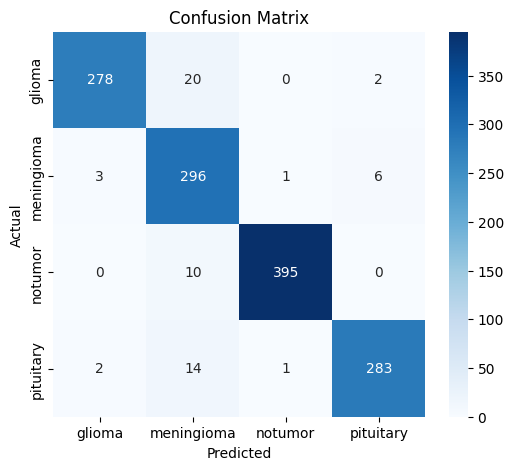

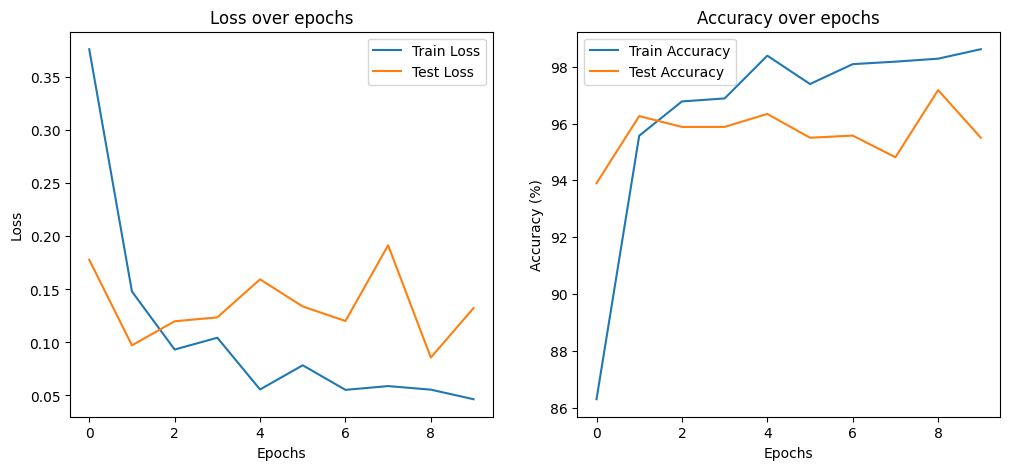

In [2]:
# ✅ Install required libraries
!pip install qiskit qiskit-machine-learning torch torchvision timm numpy matplotlib scikit-learn pillow seaborn

# ✅ Import required libraries
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import timm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# ✅ Define dataset paths
dataset_path = "/kaggle/input/brain-tumor-mri-dataset"
train_path = os.path.join(dataset_path, "Training")
test_path = os.path.join(dataset_path, "Testing")
class_labels = {"glioma": 0, "meningioma": 1, "notumor": 2, "pituitary": 3}
num_classes = len(class_labels)

# ✅ Create PyTorch Dataset Class
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data, self.labels = [], []
        for label in class_labels:
            class_path = os.path.join(root_dir, label)
            for img_file in glob.glob(os.path.join(class_path, "*")):
                self.data.append(img_file)
                self.labels.append(class_labels[label])
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx]).convert("RGB").resize((224, 224))
        return self.transform(img) if self.transform else img, self.labels[idx]

# ✅ Define Transformations and Load Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
train_dataset = BrainTumorDataset(train_path, transform)
test_dataset = BrainTumorDataset(test_path, transform)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Quantum Neural Network (QNN)
def create_qnn():
    num_qubits = 4
    ansatz = RealAmplitudes(num_qubits, reps=2)
    qc = QuantumCircuit(num_qubits)
    qc.compose(ansatz, inplace=True)
    return EstimatorQNN(circuit=qc, input_params=[], weight_params=ansatz.parameters, input_gradients=True)

# ✅ Define Q-ViT Model
class QViT(nn.Module):
    def __init__(self, quantum_layer):
        super(QViT, self).__init__()
        self.vit = timm.create_model("vit_base_patch16_224", pretrained=True)
        self.vit.head = nn.Identity()
        self.quantum_layer = quantum_layer
        self.fc1 = nn.Linear(768 + quantum_layer.neural_network.output_shape[0], 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.vit(x)
        quantum_input = torch.rand(x.size(0), self.quantum_layer.neural_network.num_inputs).to(x.device)
        quantum_out = self.quantum_layer(quantum_input)
        x = torch.cat((x, quantum_out), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# ✅ Train the Model
qnn = create_qnn()
quantum_layer = TorchConnector(qnn)
qvit_model = QViT(quantum_layer).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(qvit_model.parameters(), lr=0.0001)

train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

def train_model(model, train_loader, test_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss, correct_train = 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct_train += (outputs.argmax(dim=1) == y_batch).sum().item()

        train_acc = correct_train / len(train_loader.dataset) * 100
        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(train_acc)

        # Validate
        model.eval()
        correct_test, test_loss = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()
                correct_test += (outputs.argmax(dim=1) == y_batch).sum().item()

        test_acc = correct_test / len(test_loader.dataset) * 100
        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_acc:.2f}%")

train_model(qvit_model, train_loader, test_loader, epochs=10)
torch.save(qvit_model.state_dict(), "qvit_model.pth")

# ✅ Evaluate Model
qvit_model.eval()
y_pred, y_true = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = qvit_model(X_batch)
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y_batch.numpy())

# Classification Report
print("\n🔹 Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels.keys()))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels.keys(), yticklabels=class_labels.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ✅ Plot Accuracy and Loss Curves
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over epochs")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy over epochs")
plt.legend()

plt.show()


In [3]:
import torch
import torchvision.transforms as transforms
import timm
import torch.nn as nn
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from PIL import Image

# ✅ Define class labels
class_labels = {0: "Glioma", 1: "Meningioma", 2: "No Tumor", 3: "Pituitary"}
num_classes = len(class_labels)

# ✅ Function to create QNN
def create_qnn():
    num_qubits = 4
    ansatz = RealAmplitudes(num_qubits, reps=2)
    qc = QuantumCircuit(num_qubits)
    qc.compose(ansatz, inplace=True)
    return EstimatorQNN(circuit=qc, input_params=[], weight_params=ansatz.parameters, input_gradients=True)

# ✅ Define Q-ViT Model
class QViT(nn.Module):
    def __init__(self, quantum_layer):
        super(QViT, self).__init__()
        self.vit = timm.create_model("vit_base_patch16_224", pretrained=True)
        self.vit.head = nn.Identity()
        self.quantum_layer = quantum_layer
        self.fc1 = nn.Linear(768 + quantum_layer.neural_network.output_shape[0], 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.vit(x)
        quantum_input = torch.rand(x.size(0), self.quantum_layer.neural_network.num_inputs).to(x.device)
        quantum_out = self.quantum_layer(quantum_input)
        x = torch.cat((x, quantum_out), dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# ✅ Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
qnn = create_qnn()
quantum_layer = TorchConnector(qnn)
model = QViT(quantum_layer).to(device)
model.load_state_dict(torch.load("qvit_model.pth", map_location=device))
model.eval()

# ✅ Define Image Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# ✅ Function to predict tumor class
def predict_image(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(image)
            predicted_class = torch.argmax(output, dim=1).item()
        
        print(f"\n✅ Predicted Tumor Type: {class_labels[predicted_class]}")
    
    except Exception as e:
        print(f"❌ Error: {e}")

# ✅ Get user input and predict
image_path = input("\n🔹 Enter the path of the MRI image: ")
predict_image(image_path)


<ipython-input-3-6c972577e721>:21: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  return EstimatorQNN(circuit=qc, input_params=[], weight_params=ansatz.parameters, input_gradients=True)
<ipython-input-3-6c972577e721>:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by 


🔹 Enter the path of the MRI image:  /kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0000.jpg



✅ Predicted Tumor Type: Glioma


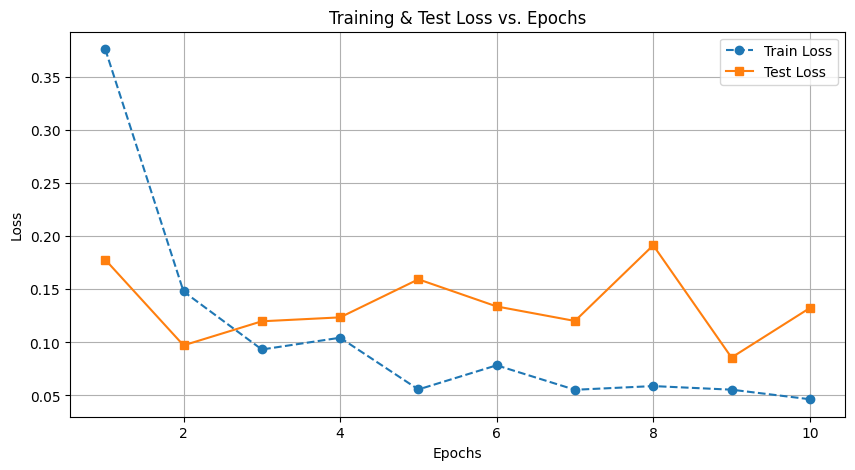

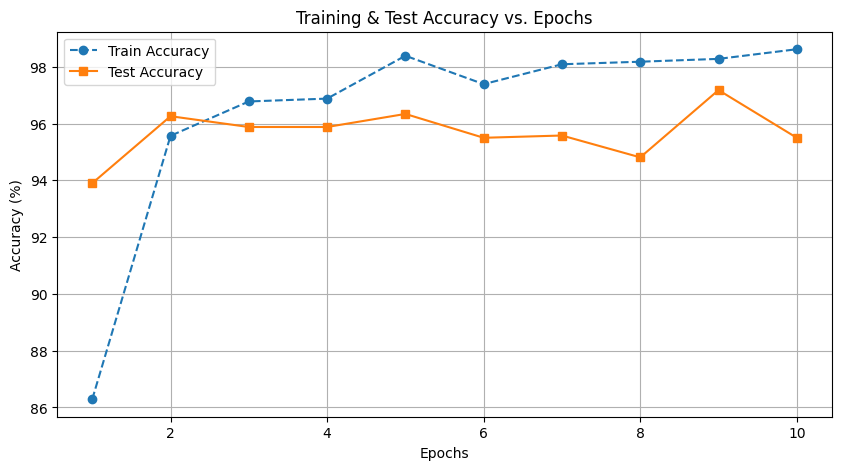

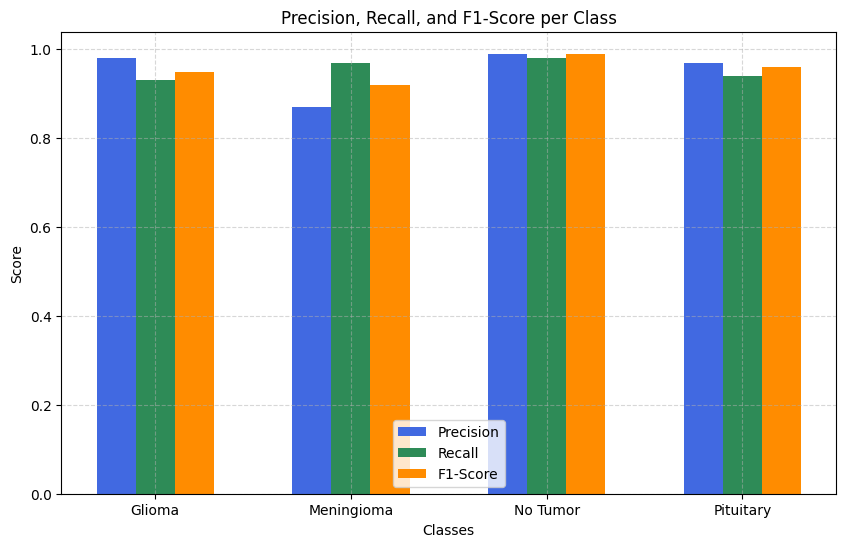

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# ✅ Training and Testing Metrics
epochs = np.arange(1, 11)
train_loss = [0.3765, 0.1480, 0.0933, 0.1044, 0.0556, 0.0784, 0.0553, 0.0588, 0.0554, 0.0464]
test_loss = [0.1780, 0.0972, 0.1199, 0.1236, 0.1595, 0.1339, 0.1202, 0.1916, 0.0857, 0.1324]
train_acc = [86.29, 95.57, 96.78, 96.88, 98.39, 97.39, 98.09, 98.18, 98.28, 98.62]
test_acc = [93.90, 96.26, 95.88, 95.88, 96.34, 95.50, 95.58, 94.81, 97.18, 95.50]

# ✅ 1. Training & Test Loss vs. Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label="Train Loss", marker='o', linestyle='--')
plt.plot(epochs, test_loss, label="Test Loss", marker='s', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Test Loss vs. Epochs")
plt.legend()
plt.grid(True)
plt.show()

# ✅ 2. Training & Test Accuracy vs. Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label="Train Accuracy", marker='o', linestyle='--')
plt.plot(epochs, test_acc, label="Test Accuracy", marker='s', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training & Test Accuracy vs. Epochs")
plt.legend()
plt.grid(True)
plt.show()

# ✅ 3. Precision, Recall, F1-Score per Class
class_labels = ["Glioma", "Meningioma", "No Tumor", "Pituitary"]
precision = [0.98, 0.87, 0.99, 0.97]
recall = [0.93, 0.97, 0.98, 0.94]
f1_score = [0.95, 0.92, 0.99, 0.96]

x = np.arange(len(class_labels))
width = 0.2

plt.figure(figsize=(10, 6))
plt.bar(x - width, precision, width=width, label="Precision", color='royalblue')
plt.bar(x, recall, width=width, label="Recall", color='seagreen')
plt.bar(x + width, f1_score, width=width, label="F1-Score", color='darkorange')

plt.xticks(ticks=x, labels=class_labels)
plt.xlabel("Classes")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-Score per Class")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

